## Importing libraries

In [1]:
#Importing libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from prettytable import PrettyTable

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

import scipy
from scipy import stats
import itertools
from statsmodels.stats.diagnostic import het_breuschpagan

## Loading the data

In [2]:
#Loading the dataset

bike = pd.read_csv('hour.csv')

## Data Cleaning

In [3]:
#Data Mapping Dictionaries

weather = {1: 'Clear',
2: 'Mist',
3: 'Light Snow/Rain',
4: 'Heavy Snow/Rain'}

season = {1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'}

year = {0: '2011', 1:'2012'}

month = {1:'Jan',
         2:'Feb',
         3:"Mar",
         4:'Apr',
         5:'May',
         6:'Jun',
         7:'Jul',
         8:'Aug',
         9:'Sept',
         10:'Oct',
         11:'Nov',
         12:'Dec'}

weekday = {0:0,
          1:1,
          2:1,
          3:1,
          4:1,
          5:1,
          6:0}

In [4]:
#Mapping the data

bike["weathersit"].replace(weather, inplace=True)
bike["season"].replace(season, inplace=True)
bike["yr"].replace(year, inplace=True)
bike["mnth"].replace(month, inplace=True)
bike["weekday"].replace(weekday, inplace=True)

In [5]:
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,Spring,2011,Jan,0,0,0,0,Clear,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,Spring,2011,Jan,1,0,0,0,Clear,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,Spring,2011,Jan,2,0,0,0,Clear,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,Spring,2011,Jan,3,0,0,0,Clear,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,Spring,2011,Jan,4,0,0,0,Clear,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
#Renaming the columns
bike.rename(columns = {'yr':'year','mnth':'month','hr':'hour','weathersit':'weather','temp':'temperature',
                      'atemp':'apparenttemperature','hum':'humidity','cnt':'count', 'weekday':'is_weekday', 'holiday':'is_holiday'}, inplace = True)

In [7]:
bike.head()

,instant,dteday,season,year,month,hour,is_holiday,is_weekday,workingday,weather,temperature,apparenttemperature,humidity,windspeed,casual,registered,count
0,1,2011-01-01,Spring,2011,Jan,0,0,0,0,Clear,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,Spring,2011,Jan,1,0,0,0,Clear,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,Spring,2011,Jan,2,0,0,0,Clear,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,Spring,2011,Jan,3,0,0,0,Clear,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,Spring,2011,Jan,4,0,0,0,Clear,0.24,0.2879,0.75,0.0,0,1,1


In [8]:
#Removing the datetime, index variable

bike = bike.drop(['instant','dteday'], axis = 1)

In [9]:
#Checking the null values
bike.isna().sum()

season                 0
year                   0
month                  0
hour                   0
is_holiday             0
is_weekday             0
workingday             0
weather                0
temperature            0
apparenttemperature    0
humidity               0
windspeed              0
casual                 0
registered             0
count                  0
dtype: int64

There is no missing value in this dataset.

In [10]:
bike.describe()

,hour,is_holiday,is_weekday,workingday,temperature,apparenttemperature,humidity,windspeed,casual,registered,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,11.546752,0.028770,0.711491,0.682721,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,6.914405,0.167165,0.453082,0.465431,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6.000000,0.000000,0.000000,0.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,12.000000,0.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,18.000000,0.000000,1.000000,1.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [11]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   season               17379 non-null  object 
 1   year                 17379 non-null  object 
 2   month                17379 non-null  object 
 3   hour                 17379 non-null  int64  
 4   is_holiday           17379 non-null  int64  
 5   is_weekday           17379 non-null  int64  
 6   workingday           17379 non-null  int64  
 7   weather              17379 non-null  object 
 8   temperature          17379 non-null  float64
 9   apparenttemperature  17379 non-null  float64
 10  humidity             17379 non-null  float64
 11  windspeed            17379 non-null  float64
 12  casual               17379 non-null  int64  
 13  registered           17379 non-null  int64  
 14  count                17379 non-null  int64  
dtypes: float64(4), int64(7), object(4)
m

In [12]:
bike.describe()

,hour,is_holiday,is_weekday,workingday,temperature,apparenttemperature,humidity,windspeed,casual,registered,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,11.546752,0.028770,0.711491,0.682721,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,6.914405,0.167165,0.453082,0.465431,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6.000000,0.000000,0.000000,0.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,12.000000,0.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,18.000000,0.000000,1.000000,1.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


No anomalies sighted.

In [13]:
bike.shape

(17379, 15)

In [14]:
#Checking the duplicates
bike.duplicated().sum()

5

There are 5 duplicate rows in this dataset. Let's drop them.

In [15]:
#Removing the duplicates
bike.drop_duplicates(inplace=True)

In [16]:
bike.shape

(17374, 15)

## Exploratory Data Analysis

### Univariate Analysis

In [17]:
num_columns = bike.select_dtypes(exclude=['object']).columns
cat_columns = bike.select_dtypes(include=['object']).columns

In [18]:
len(num_columns)

11

In [19]:
len(cat_columns)

4

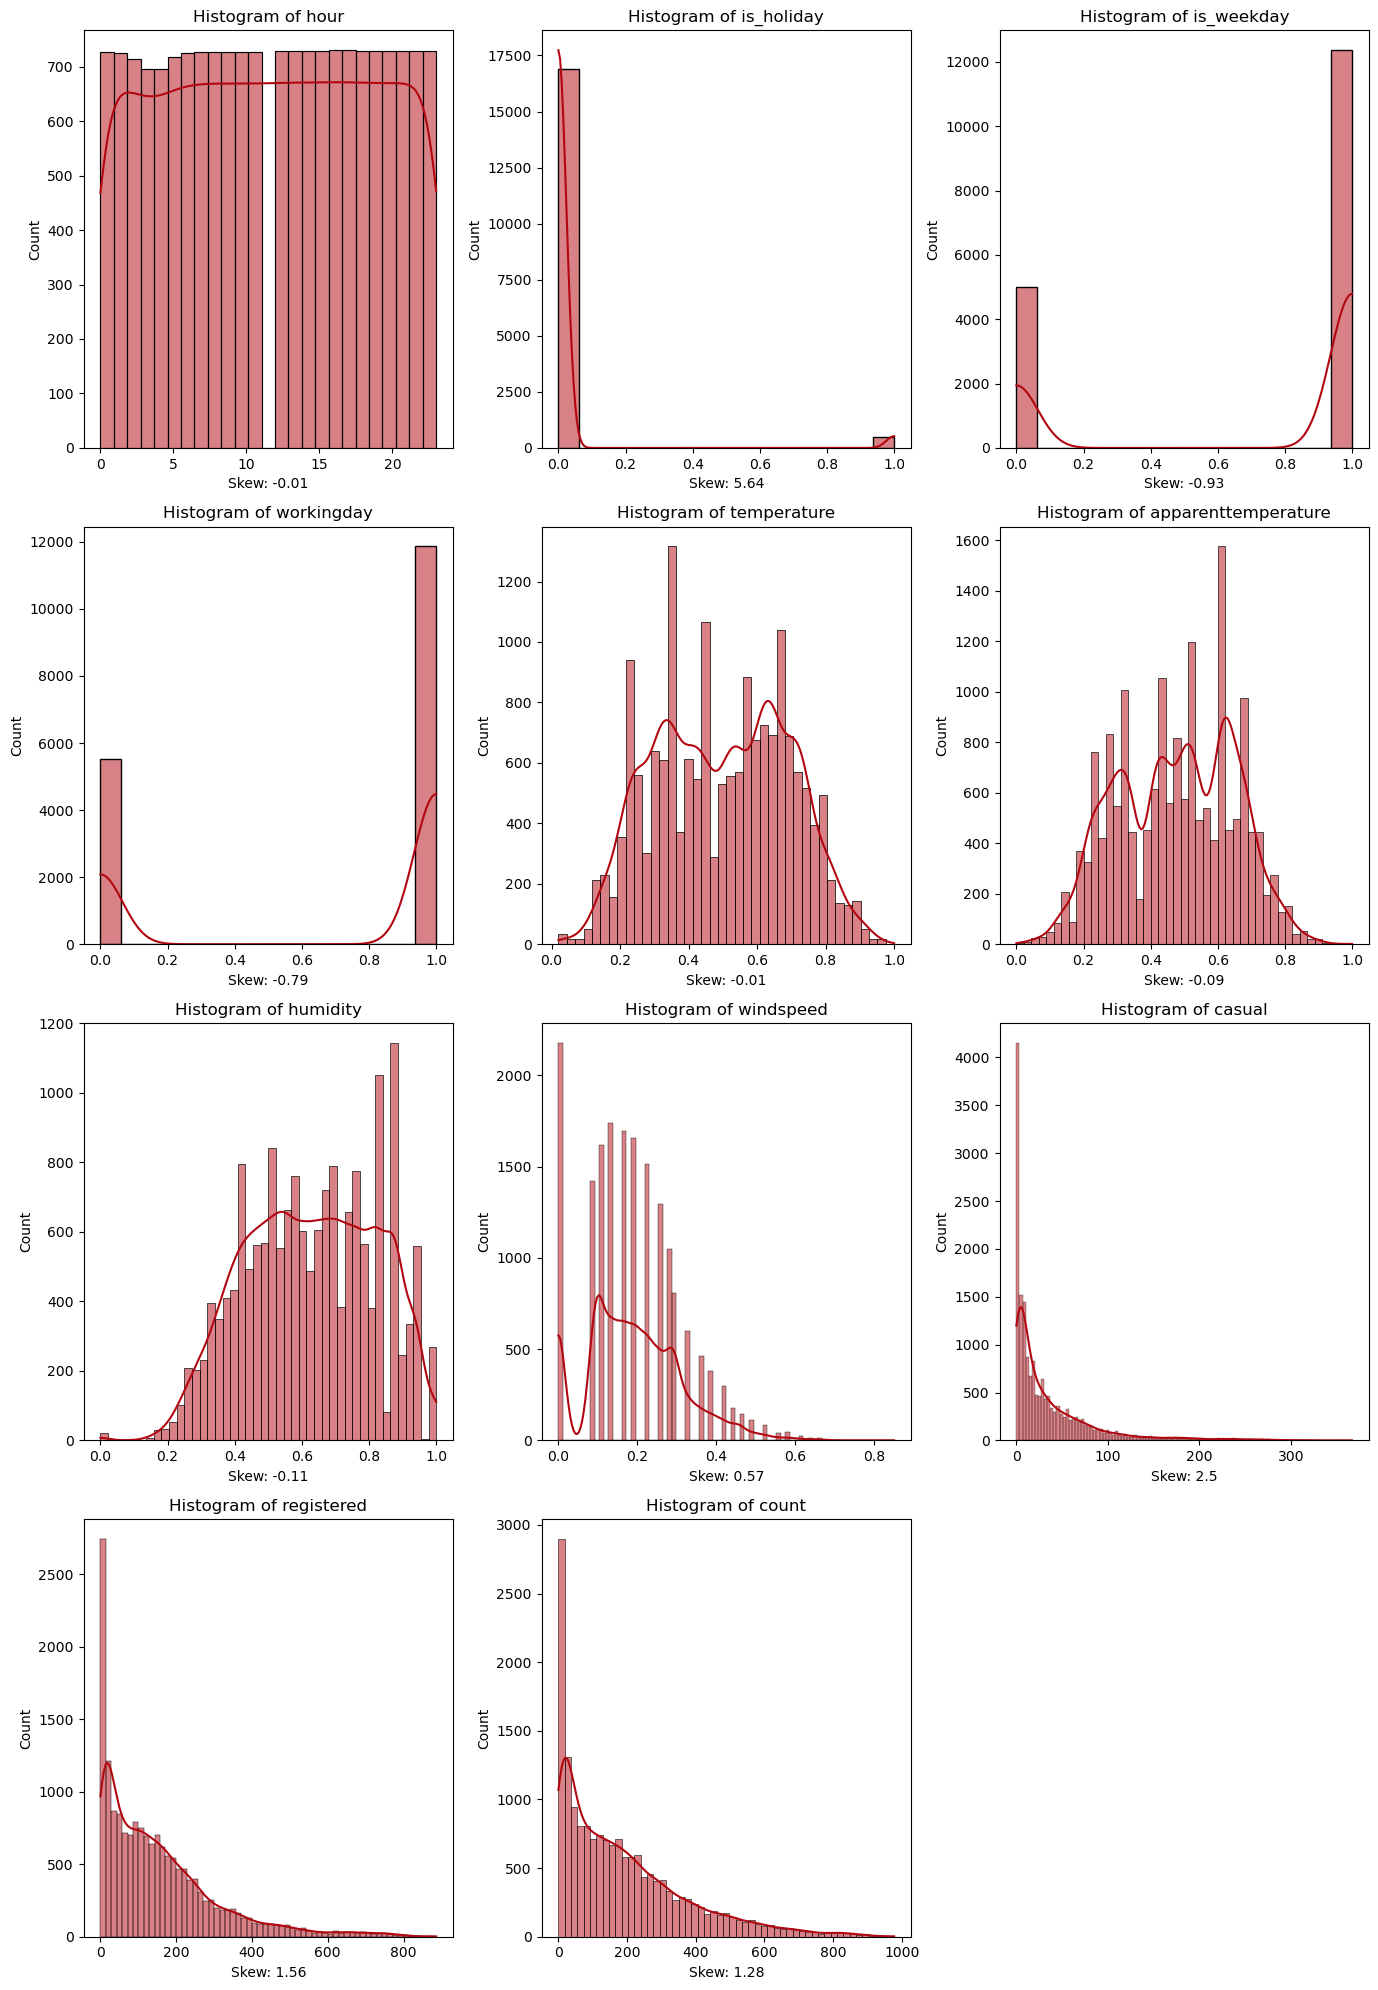

In [20]:
# Checking the distribution of continuous features

i = 1
fig, ax = plt.subplots(4, 3, figsize=(14, 20))

for feature in num_columns:
    plt.subplot(4,3, i)
    plt.title(f'Histogram of {feature}')
    sns.histplot(data = bike, x = feature, kde = True, color = '#b20710')
    plt.xlabel(f'Skew: {round(bike[feature].skew(), 2)}')
    i += 1

fig.tight_layout()
fig.delaxes(ax[3][2])

plt.show()

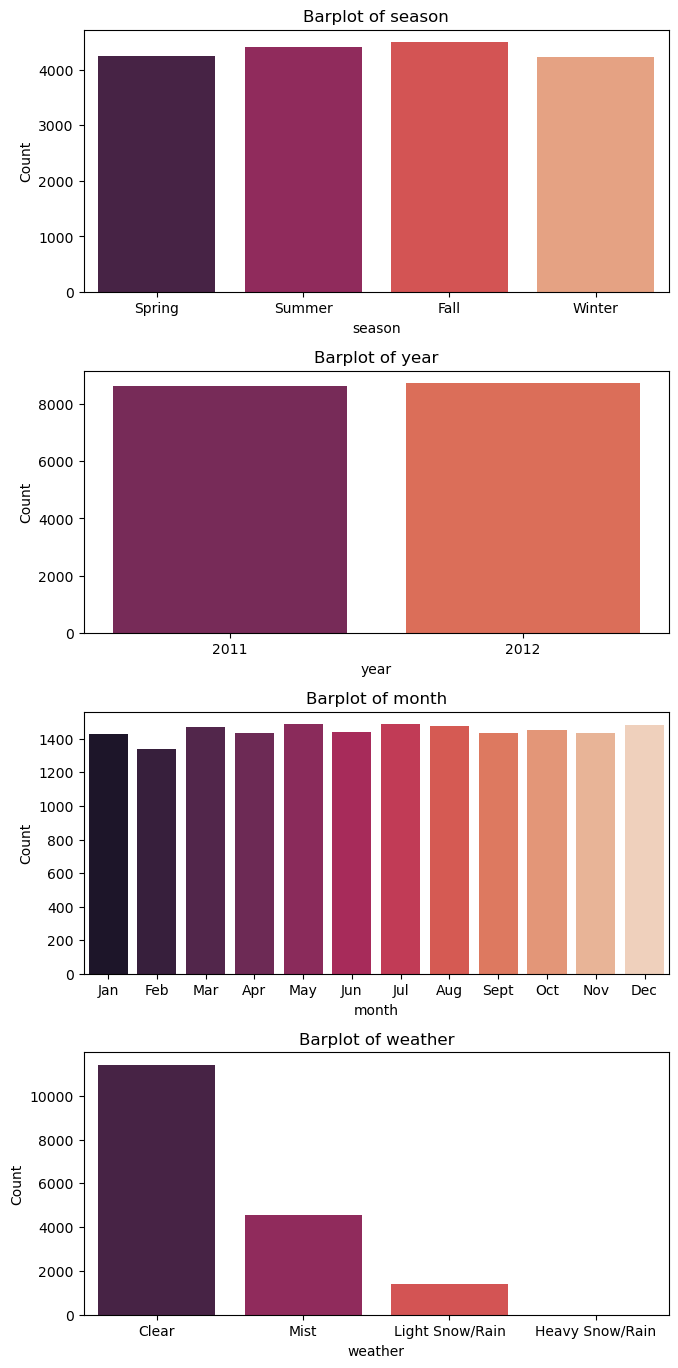

In [21]:
# Checking the distribution of categorical features

fig, axes = plt.subplots(5, 1, figsize=(7,17))

# Flatten the axes for iteration
axes = axes.flatten()

# Loop through each categorical column and create a bar plot
for i, column in enumerate(cat_columns):
    sns.countplot(x=column, data=bike, ax=axes[i], palette="rocket")
    axes[i].set_title(f'Barplot of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    plt.tight_layout()

fig.delaxes(axes[4])

# Show the plots
plt.show()

### Bi-Variate Analysis

In [22]:
num_columns

Index(['hour', 'is_holiday', 'is_weekday', 'workingday', 'temperature',
       'apparenttemperature', 'humidity', 'windspeed', 'casual', 'registered',
       'count'],
      dtype='object')

In [23]:
cat_columns

Index(['season', 'year', 'month', 'weather'], dtype='object')

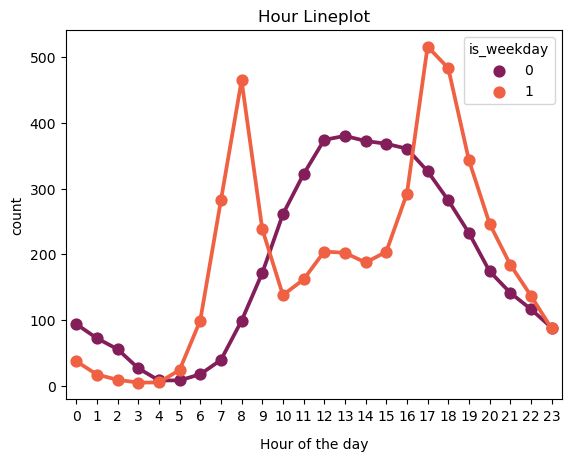

In [24]:
sns.pointplot(data=bike, x="hour", y = "count", hue = 'is_weekday', palette = 'rocket', ci=None)
plt.title('Hour Lineplot', size=12)
plt.xlabel('Hour of the day', size=10, labelpad=10)
plt.show()

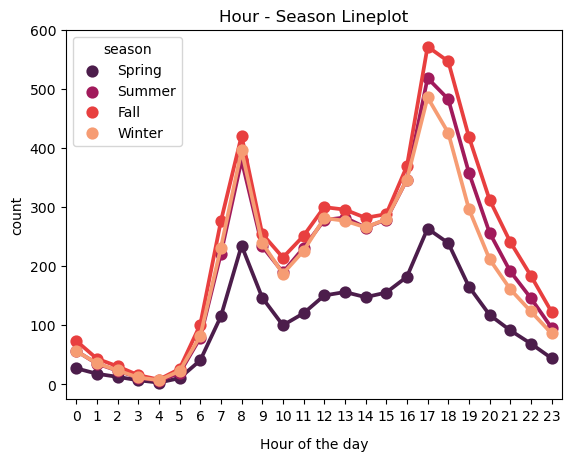

In [25]:
sns.pointplot(data=bike, x="hour", y = "count", hue = 'season', palette = 'rocket', ci=None)
plt.title('Hour - Season Lineplot', size=12)
plt.xlabel('Hour of the day', size=10, labelpad=10)
plt.show()

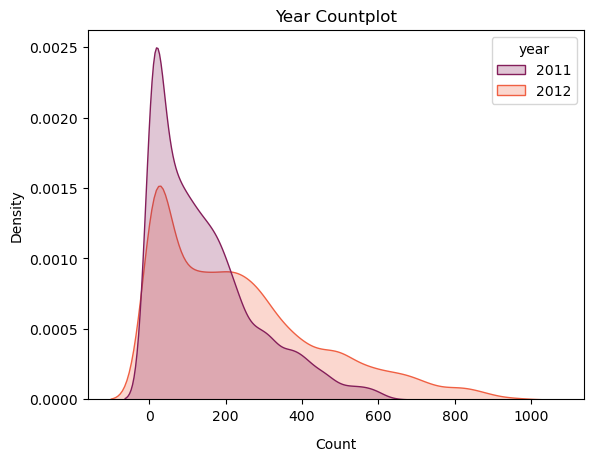

In [26]:
sns.kdeplot(data=bike, x="count", hue = 'year', palette = 'rocket', shade = True)
plt.title('Year Countplot', size=12)
plt.xlabel('Count', size=10, labelpad=10)
plt.show()

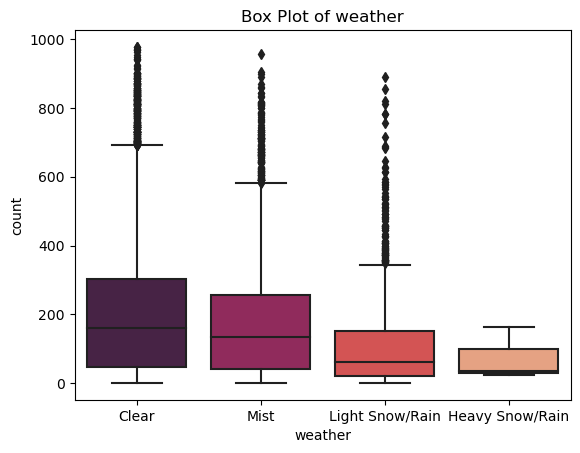

In [27]:
sns.boxplot(x='weather', y='count', data=bike, palette = 'rocket')
plt.title('Box Plot of weather')
plt.show()

### Multi-Variate Analysis

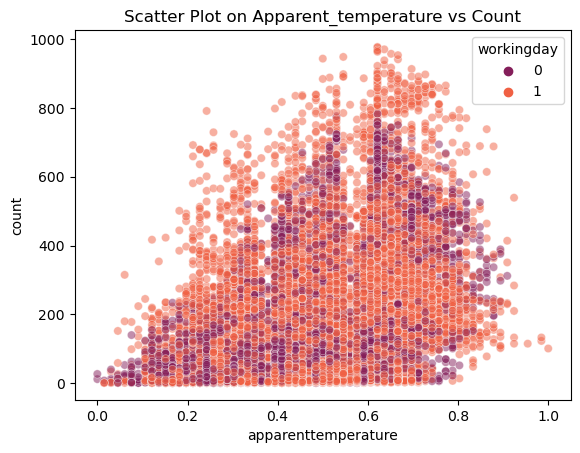

In [28]:
# Scatter plot
sns.scatterplot(x='apparenttemperature', y='count', hue = 'workingday', data=bike, palette = 'rocket', alpha=.5)
plt.title('Scatter Plot on Apparent_temperature vs Count')
plt.show()

### Checking for Multicollinearity

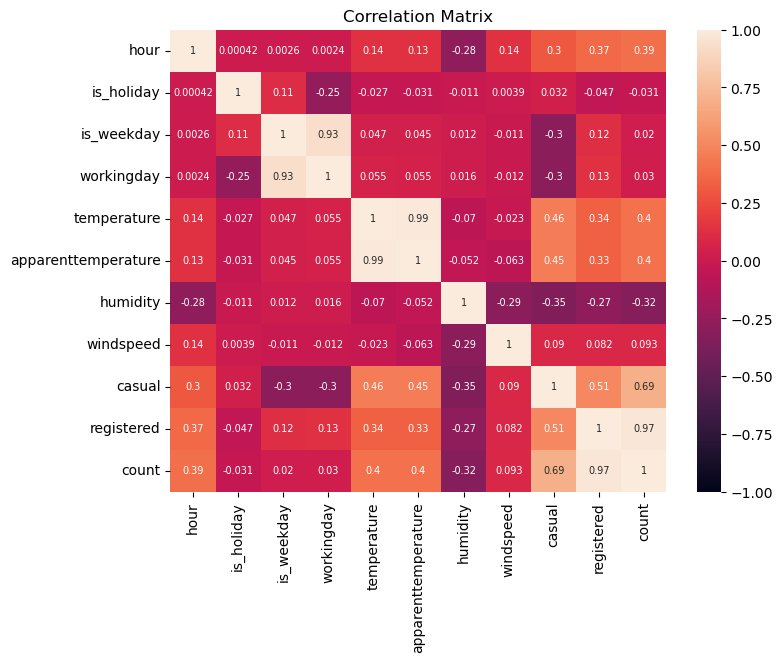

In [29]:
#Let's check how the features are inter-related to each other and with target variable
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.set_title("Correlation Matrix", fontsize=12)
sns.heatmap(bike.corr(), vmin=-1, vmax=1, annot=True, cmap = 'rocket', annot_kws={"size":7})

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10) 
    tick.label.set_rotation(90) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
    tick.label.set_rotation(0) 
plt.show()

In [30]:
bike.head()

,season,year,month,hour,is_holiday,is_weekday,workingday,weather,temperature,apparenttemperature,humidity,windspeed,casual,registered,count
0,Spring,2011,Jan,0,0,0,0,Clear,0.24,0.2879,0.81,0.0,3,13,16
1,Spring,2011,Jan,1,0,0,0,Clear,0.22,0.2727,0.80,0.0,8,32,40
2,Spring,2011,Jan,2,0,0,0,Clear,0.22,0.2727,0.80,0.0,5,27,32
3,Spring,2011,Jan,3,0,0,0,Clear,0.24,0.2879,0.75,0.0,3,10,13
4,Spring,2011,Jan,4,0,0,0,Clear,0.24,0.2879,0.75,0.0,0,1,1


In [31]:
bike.columns

Index(['season', 'year', 'month', 'hour', 'is_holiday', 'is_weekday',
       'workingday', 'weather', 'temperature', 'apparenttemperature',
       'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [32]:
cat_columns

Index(['season', 'year', 'month', 'weather'], dtype='object')

In [33]:
num_columns

Index(['hour', 'is_holiday', 'is_weekday', 'workingday', 'temperature',
       'apparenttemperature', 'humidity', 'windspeed', 'casual', 'registered',
       'count'],
      dtype='object')

In [34]:
#Checking the VIF for each variable
y, X = dmatrices('count~humidity+temperature+apparenttemperature+windspeed+C(weather)+C(season)+casual+registered+hour+is_holiday+is_weekday+C(month)+C(year)+workingday', data=bike, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                       features
0   118.739069                      Intercept
1     1.003148  C(weather)[T.Heavy Snow/Rain]
2     1.272442  C(weather)[T.Light Snow/Rain]
3     1.165111             C(weather)[T.Mist]
4    10.228692            C(season)[T.Spring]
5     7.868323            C(season)[T.Summer]
6     8.234225            C(season)[T.Winter]
7     5.483144                C(month)[T.Aug]
8     5.302250                C(month)[T.Dec]
9     4.849149                C(month)[T.Feb]
10    5.325437                C(month)[T.Jan]
11    5.660041                C(month)[T.Jul]
12    2.627121                C(month)[T.Jun]
13    3.195975                C(month)[T.Mar]
14    2.093734                C(month)[T.May]
15    6.192519                C(month)[T.Nov]
16    6.086167                C(month)[T.Oct]
17    4.755080               C(month)[T.Sept]
18    1.098596                C(year)[T.2012]
19    1.779642                       humidity
20   53.679940                    

In [35]:
#Removing multicollinearity from the data

bike.drop(['registered','temperature','workingday'], axis = 1, inplace = True)

In [36]:
num_columns = bike.select_dtypes(exclude=['object']).columns
cat_columns = bike.select_dtypes(include=['object']).columns

In [37]:
#Checking the VIF again

y, X = dmatrices('count~humidity+apparenttemperature+windspeed+C(weather)+C(season)+casual+hour+is_holiday+is_weekday+C(month)+C(year)', data=bike, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                       features
0   118.320737                      Intercept
1     1.003129  C(weather)[T.Heavy Snow/Rain]
2     1.263581  C(weather)[T.Light Snow/Rain]
3     1.162367             C(weather)[T.Mist]
4    10.206236            C(season)[T.Spring]
5     7.842814            C(season)[T.Summer]
6     8.210231            C(season)[T.Winter]
7     5.284272                C(month)[T.Aug]
8     5.279579                C(month)[T.Dec]
9     4.823006                C(month)[T.Feb]
10    5.289964                C(month)[T.Jan]
11    5.507640                C(month)[T.Jul]
12    2.490613                C(month)[T.Jun]
13    3.192335                C(month)[T.Mar]
14    2.040214                C(month)[T.May]
15    6.176367                C(month)[T.Nov]
16    6.085931                C(month)[T.Oct]
17    4.693312               C(month)[T.Sept]
18    1.035109                C(year)[T.2012]
19    1.764634                       humidity
20    4.675204            apparent

## Fitting Initial Linear Regression Model

In [38]:
# Fitting the model

reg = smf.ols('count~humidity+apparenttemperature+windspeed+C(weather)+C(season)+casual+hour+is_holiday+is_weekday+C(month)+C(year)', data=bike).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     1100.
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        18:25:53   Log-Likelihood:            -1.0676e+05
No. Observations:               17374   AIC:                         2.136e+05
Df Residuals:                   17348   BIC:                         2.138e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -51.6060      9.317     -5.539      0.000     -69.869     -33.343
C(weather)[T.Heavy Snow/Rain]    -5.0541     65.292     -0.077      0.938    -133.033     122.925
C(weather)[T.Light Snow/Rain]   -29.2416      3.516     -8.317      0.000     -36.133     -22.350
C(weather)[T.Mist]                1.9318      2.101      0.919      0.358      -2.187       6.051
C(season)[T.Spring]             -27.8767      6.370     -4.376      0.000     -40.363     -15.390
C(season)[T.Summer]             -10.6581      5.512     -1.933      0.053     -21.463       0.147
C(season)[T.Winter]              34.9322      5.719      6.108      0.000      23.723      46.141
C(month)[T.Aug]                  10.6285      7.064      1.505      0.132      -3.218      24.475
C(month)[T.Dec]                   7.8548      7.046      1.115      0.265      -5.956      21.666
C(month)[T.Feb]                  20.9409      7.051      2.970      0.003       7.121      34.761
C(month)[T.Jan]                  15.5326      7.171      2.166      0.030       1.478      29.588
C(month)[T.Jul]                  -1.0716      7.186     -0.149      0.881     -15.156      13.013
C(month)[T.Jun]                  15.0834      4.903      3.076      0.002       5.473      24.694
C(month)[T.Mar]                   6.0869      5.494      1.108      0.268      -4.682      16.856
C(month)[T.May]                  13.7813      4.372      3.152      0.002       5.212      22.351
C(month)[T.Nov]                  -9.2218      7.731     -1.193      0.233     -24.375       5.931
C(month)[T.Oct]                  -2.2867      7.638     -0.299      0.765     -17.258      12.684
C(month)[T.Sept]                 18.7326      6.739      2.780      0.005       5.523      31.942
C(year)[T.2012]                  56.5360      1.743     32.437      0.000      53.120      59.952
humidity                        -36.1228      5.898     -6.125      0.000     -47.683     -24.563
apparenttemperature              53.5794     10.777      4.972      0.000      32.455      74.703
windspeed                        38.6669      7.547      5.124      0.000      23.874      53.460
casual                            2.3278      0.024     96.733      0.000       2.281       2.375
hour                              4.8243      0.136     35.371      0.000       4.557       5.092
is_holiday                      -79.7775      5.238    -15.231      0.000     -90.044     -69.511
is_weekday                       85.7424      2.094     40.938      0.000      81.637      89.848
==============================================================================
Omnibus:                     6247.750   Durbin-Watson:                   0.687
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23139.511
Skew

## Infulencial Points

In [39]:
bike.columns

Index(['season', 'year', 'month', 'hour', 'is_holiday', 'is_weekday',
       'weather', 'apparenttemperature', 'humidity', 'windspeed', 'casual',
       'count'],
      dtype='object')

In [40]:
#Checking influential points

n = len(bike)
p = bike.shape[1]
infl = reg.get_influence()
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)

#detection - absolute value > threshold
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud

infuential_std=set(bike.index[atyp_stud])

inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n
infu_cook=set(bike.index[atyp_cook])

print("numbr of outliers::",len(infuential_std & infu_cook))

numbr of outliers:: 814


In [41]:
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n
infu_cook=set(bike.index[atyp_cook])
print(bike.index[atyp_cook],reg_cook[atyp_cook],reg.resid[bike.index[atyp_cook]])

Int64Index([  585,  2129,  2410,  2530,  2674,  2684,  2698,  2707,  2722,
             2732,
            ...
            17039, 17053, 17062, 17063, 17077, 17086, 17087, 17101, 17116,
            17125],
           dtype='int64', length=911) 585      0.005646
2129     0.000372
2410     0.000560
2530     0.000285
2674     0.000326
           ...   
17086    0.000288
17087    0.000302
17101    0.000617
17116    0.000249
17125    0.000660
Name: cooks_d, Length: 911, dtype: float64 585      -49.914815
2129    -233.304051
2410     256.131104
2530     257.273576
2674     301.648426
            ...    
17086    267.138339
17087    278.268043
17101    399.852195
17116   -206.018626
17125    335.589598
Length: 911, dtype: float64


In [42]:
outliers_set = infuential_std & infu_cook

In [43]:
print(outliers_set)

{10240, 12291, 16391, 8200, 16392, 10254, 6162, 16406, 10263, 10264, 6172, 8224, 10278, 14379, 6196, 14388, 14389, 8248, 4162, 6210, 14403, 12362, 4171, 4172, 6219, 6220, 12363, 8272, 2129, 14412, 14413, 12372, 12373, 16461, 4186, 6234, 14426, 14427, 12386, 4195, 6243, 6244, 12387, 14436, 14437, 12396, 10349, 12397, 4210, 14450, 14451, 10358, 10359, 12410, 12411, 14460, 4220, 14461, 12420, 10373, 12421, 4234, 14475, 10382, 10383, 16526, 12434, 12435, 16535, 8344, 12444, 10397, 12445, 4258, 10406, 10407, 16550, 12458, 12459, 16559, 8368, 16560, 12468, 10421, 10430, 10431, 16574, 6339, 6340, 16583, 8392, 16584, 10445, 6354, 16597, 6363, 16606, 16607, 8416, 14570, 14571, 10476, 10477, 16621, 12530, 6387, 12531, 14580, 14581, 16630, 16631, 12540, 12541, 6402, 14594, 14595, 6411, 12555, 14604, 14605, 14606, 12564, 10517, 12565, 6426, 14618, 14619, 10526, 10527, 12578, 12579, 14628, 14629, 12588, 10541, 12589, 4402, 14642, 14643, 16693, 10550, 10551, 12602, 12603, 14652, 14653, 16702, 16703,

In [44]:
print(len(outliers_set))

814


In [45]:
bike_v1 = bike.drop(list(outliers_set))

In [46]:
bike_v1.shape

(16560, 12)

## Checking Heteroscedasticity

{'BP Statistic': 1320.7624758601821, 'BP-Test p-value': 3.155772606274767e-263}


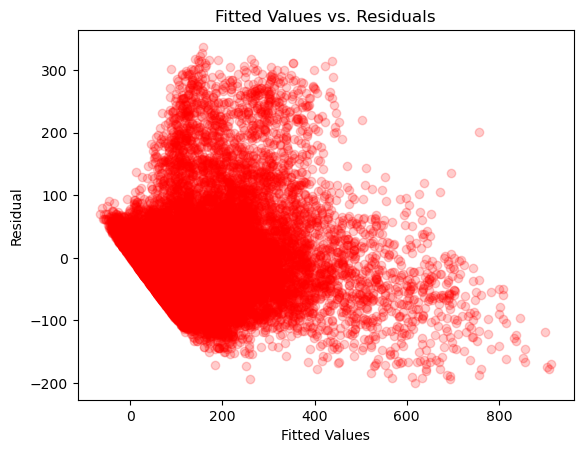

In [47]:
# residual_plot

reg = smf.ols('count~humidity+apparenttemperature+windspeed+C(weather)+C(season)+casual+hour+is_holiday+is_weekday+C(month)+C(year)', data=bike_v1).fit()

p = reg.fittedvalues
res = reg.resid
plt.scatter(p,res, c='red', alpha = 0.2)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")
# 11:36
#Breusch-Pagan for Heteroskedasticity

bp_test = het_breuschpagan(reg.resid, reg.model.exog)
labels = ['BP Statistic', 'BP-Test p-value']
print(dict(zip(labels, bp_test)))

## Checking Normality

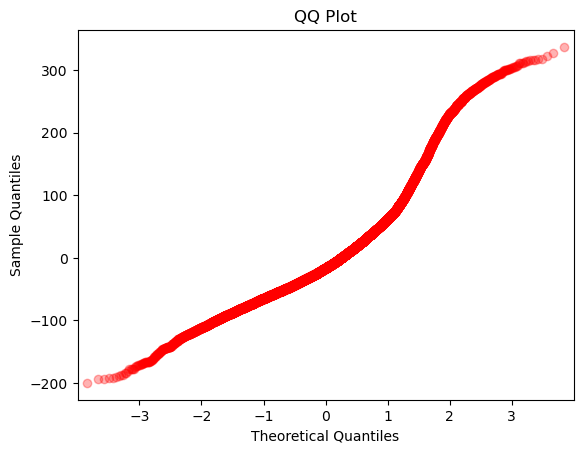

In [48]:
#QQ Plot
sm.qqplot(reg.resid, markerfacecolor='r', markeredgecolor='r', alpha=0.3)
plt.title("QQ Plot")
plt.show()

In [49]:
jb_value, p_value = stats.jarque_bera(reg.resid)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The residuals are not normally distributed.")#h1
else:
    print("Fail to reject the null hypothesis: The residuals are normally distributed.")#h0
print("Jarque-Bera statistic:", jb_value)
print("p-value:", p_value)

Reject the null hypothesis: The residuals are not normally distributed.
Jarque-Bera statistic: 8018.905944749717
p-value: 0.0


<Axes: xlabel='count', ylabel='Density'>

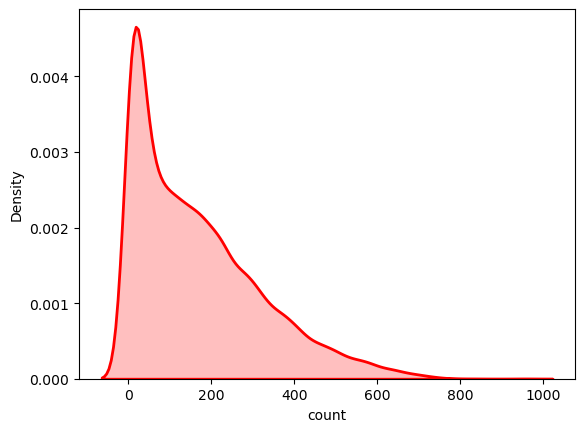

In [50]:
sns.distplot(bike_v1['count'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="red")

In [51]:
bike_v1['count'], fitted_lambda = stats.boxcox(bike_v1['count'])

<Axes: xlabel='count', ylabel='Density'>

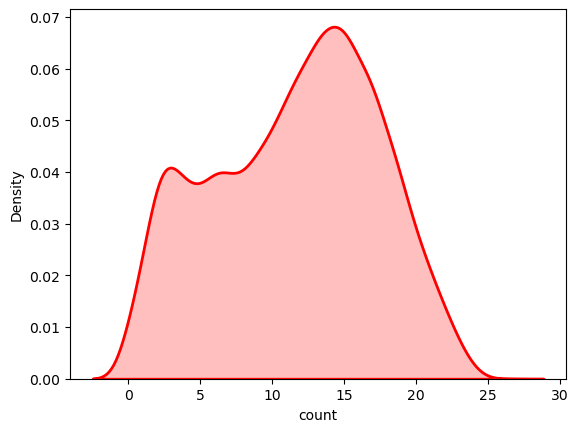

In [52]:
sns.distplot(bike_v1['count'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="red")

## Fitting Final Linear Regression Model

In [53]:
# Fitting the final linear regression model

reg2 = smf.ols('count~humidity+apparenttemperature+windspeed+C(weather)+C(season)+casual+hour+is_holiday+is_weekday+C(month)+C(year)', data=bike_v1).fit()
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     1391.
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        18:33:03   Log-Likelihood:                -42987.
No. Observations:               16560   AIC:                         8.603e+04
Df Residuals:                   16534   BIC:                         8.623e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.3644      0.275     12.221      0.000       2.825       3.904
C(weather)[T.Heavy Snow/Rain]     1.1825      1.878      0.630      0.529      -2.498       4.863
C(weather)[T.Light Snow/Rain]    -0.8993      0.103     -8.721      0.000      -1.101      -0.697
C(weather)[T.Mist]                0.4331      0.062      6.998      0.000       0.312       0.554
C(season)[T.Spring]              -1.1022      0.188     -5.852      0.000      -1.471      -0.733
C(season)[T.Summer]              -0.3015      0.164     -1.837      0.066      -0.623       0.020
C(season)[T.Winter]               1.0381      0.170      6.104      0.000       0.705       1.371
C(month)[T.Aug]                  -0.0933      0.210     -0.445      0.657      -0.504       0.318
C(month)[T.Dec]                   0.7117      0.207      3.434      0.001       0.306       1.118
C(month)[T.Feb]                   1.2263      0.207      5.924      0.000       0.821       1.632
C(month)[T.Jan]                   1.0577      0.210      5.026      0.000       0.645       1.470
C(month)[T.Jul]                  -0.4779      0.213     -2.242      0.025      -0.896      -0.060
C(month)[T.Jun]                  -0.1461      0.146     -1.003      0.316      -0.432       0.139
C(month)[T.Mar]                   0.4994      0.162      3.087      0.002       0.182       0.816
C(month)[T.May]                   0.4781      0.129      3.702      0.000       0.225       0.731
C(month)[T.Nov]                   0.1908      0.228      0.837      0.403      -0.256       0.638
C(month)[T.Oct]                  -0.0333      0.225     -0.147      0.883      -0.475       0.409
C(month)[T.Sept]                  0.1558      0.200      0.779      0.436      -0.236       0.548
C(year)[T.2012]                   1.0169      0.051     19.840      0.000       0.916       1.117
humidity                         -2.7779      0.173    -16.015      0.000      -3.118      -2.438
apparenttemperature               5.2312      0.318     16.463      0.000       4.608       5.854
windspeed                         1.4297      0.222      6.432      0.000       0.994       1.865
casual                            0.0601      0.001     83.920      0.000       0.059       0.062
hour                              0.2963      0.004     75.004      0.000       0.289       0.304
is_holiday                       -1.8677      0.152    -12.251      0.000      -2.166      -1.569
is_weekday                        1.4693      0.061     24.007      0.000       1.349       1.589
==============================================================================
Omnibus:                      154.455   Durbin-Watson:                   0.608
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.610
Skew

### Sequential F-Test

In [54]:
# Showing the type-1 ANOVA test results
anova_results_typ1 = sm.stats.anova_lm(reg2, typ=1)
anova_results_typ1

,df,sum_sq,mean_sq,F,PR(>F)
C(weather),3.0,12018.667925,4006.222642,380.016624,1.045577e-238
C(season),3.0,31314.535101,10438.178367,990.130021,0.000000e+00
C(month),11.0,5376.312308,488.755664,46.361696,9.829755e-101
C(year),1.0,14383.215345,14383.215345,1364.342781,4.765986e-287
humidity,1.0,84434.055987,84434.055987,8009.126752,0.000000e+00
apparenttemperature,1.0,51522.699200,51522.699200,4887.267627,0.000000e+00
windspeed,1.0,1324.281547,1324.281547,125.616834,4.746914e-29
casual,1.0,97138.928273,97138.928273,9214.267631,0.000000e+00
hour,1.0,62211.912946,62211.912946,5901.210009,0.000000e+00
is_holiday,1.0,807.881790,807.881790,76.632913,2.254533e-18


### Marginal F-Test

In [55]:
# Showing the type-2 ANOVA test results
anova_results_typ2 = sm.stats.anova_lm(reg2, typ=2)
anova_results_typ2

,sum_sq,df,F,PR(>F)
C(weather),1835.986342,3.0,58.051802,2.529531e-37
C(season),1998.046579,3.0,63.175963,1.315922e-40
C(month),1061.869046,11.0,9.156843,1.456486e-16
C(year),4149.612355,1.0,393.618084,1.370485e-86
humidity,2703.802366,1.0,256.473476,2.717080e-57
apparenttemperature,2857.174628,1.0,271.021846,2.055242e-60
windspeed,436.081990,1.0,41.365251,1.297470e-10
casual,74244.115779,1.0,7042.543757,0.000000e+00
hour,59305.897998,1.0,5625.555336,0.000000e+00
is_holiday,1582.348442,1.0,150.096180,2.327791e-34


## Model Selection- Best Linear Regression Model

All the variables are significant based on t-test and ANOVA test results

In [56]:
# Define the list of all predictors
predictors = ['humidity','apparenttemperature','windspeed','C(weather)','C(season)','casual','hour','is_holiday','is_weekday','C(month)','C(year)']

# Generate all possible combinations of predictors
all_models = []

for r in range(1, len(predictors) + 1):
    for combo in itertools.combinations(predictors, r):
        model_formula = 'count ~ ' + ' + '.join(combo)
        all_models.append(model_formula)

# Print all possible models
# for model_formula in all_models:
#     print(model_formula)

full_mse=reg2.mse_resid
n=len(bike_v1)

def calculate_CP (model,full_mse,n,k):
    num=model.mse_resid * model.df_resid
    denom=full_mse
    interm=num/denom
    return interm - (n-2*k)

model_list=[]
for model in all_models:
    temp={}
    number_of_pred=len(model.split('~')[1].split('+'))
    temp['model']=model
    temp['Number_of_predictors']=number_of_pred
    temp['2k']=2*(number_of_pred+1)
    red_model =smf.ols(model,data=bike_v1).fit()
    temp['R_squared']=red_model.rsquared
    temp['Adj_r_sqr']=red_model.rsquared_adj
    temp['cp']= calculate_CP (red_model,full_mse,n,number_of_pred+1)
    temp['Predictors']=model.split('~')[1]
    temp['AIC']=red_model.aic
    temp['BIC']=red_model.bic
    model_list.append(temp)
    
summary_table=pd.DataFrame(model_list)

summary_table.head()

,model,Number_of_predictors,2k,R_squared,Adj_r_sqr,cp,Predictors,AIC,BIC
0,count ~ humidity,1,4,0.139883,0.139831,27575.941510,humidity,102236.494732,102251.924223
1,count ~ apparenttemperature,1,4,0.173246,0.173196,25864.116998,apparenttemperature,101581.362745,101596.792236
2,count ~ windspeed,1,4,0.014436,0.014376,34012.541935,windspeed,104491.070248,104506.499739
3,count ~ C(weather),1,4,0.022219,0.022042,33613.192604,C(weather),104363.773677,104394.632659
4,count ~ C(season),1,4,0.060801,0.060631,31633.581556,C(season),103697.096266,103727.955248


### Final Linear Regression Model

In [57]:
summary_table[summary_table['Adj_r_sqr'] == max(summary_table['Adj_r_sqr'])]['model'].values

array(['count ~ humidity + apparenttemperature + windspeed + C(weather) + C(season) + casual + hour + is_holiday + is_weekday + C(month) + C(year)'],
      dtype=object)

In [58]:
summary_table[summary_table['Adj_r_sqr'] == max(summary_table['Adj_r_sqr'])]

,model,Number_of_predictors,2k,R_squared,Adj_r_sqr,cp,Predictors,AIC,BIC
2046,count ~ humidity + apparenttemperature + winds...,11,24,0.677758,0.677271,-2.0,humidity + apparenttemperature + windspeed + ...,86026.467148,86227.050529


## Trying out other regression models

### Data-Preprocessing

In [59]:
#Creating dummy variables
bike_encoded_v1 = pd.get_dummies(bike_v1, columns=cat_columns)

In [60]:
#Applying standard scaler on numerical columns

scaler = StandardScaler()
# transform data
bike_encoded_v1[num_columns] = scaler.fit_transform(bike_encoded_v1[num_columns])

### Splitting the data

In [61]:
#Separating the target variable
y = bike_encoded_v1['count']
X = bike_encoded_v1.drop(['count'], axis = 1)

#Splitting the training data into 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

### Naive Model

In [62]:
# Let's get a benchmark score
scores_dict = {}

model_dummy = DummyRegressor(strategy='median')
model_dummy.fit(X_train, y_train)
y_dummy = model_dummy.predict(X_test)
score_dummy = r2_score(y_test, y_dummy)
print(f'Dummy Regressor- R2 Score: {score_dummy}')

scores_dict['Dummy Regressor'] = round(score_dummy,4)

Dummy Regressor- R2 Score: -0.01540173230268449


### Linear Regression

In [63]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = r2_score(y_test, y_pred)
print(f'Linear Regression- R2 Score: {score}')

scores_dict['Linear Regression'] = round(score,4)

Linear Regression- R2 Score: 0.6809567049310399


### Better Models

In [64]:
model_names = ["Lasso Regression", "Ridge Regression", "Decision Tree"]

models = [
    Lasso(fit_intercept=True),
    Ridge(fit_intercept=True),
    DecisionTreeRegressor()]

for name, model in zip(model_names, models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    print(f'{name}: R2 Score: {score}')
    
    scores_dict[name] = round(score,4)

Lasso Regression: R2 Score: -1.2865465236933105e-05
Ridge Regression: R2 Score: 0.6814490448626696
Decision Tree: R2 Score: 0.929340144920525


### Advanced- Ensemble Models

In [65]:
model_names = ["LGBM", "Random Forest", "XGBoost"]

models = [
    LGBMRegressor(),
    RandomForestRegressor(n_estimators = 10, max_depth = 10),
    XGBRegressor()]

for name, model in zip(model_names, models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    print(f'{name}: R2 Score: {score}')
    
    scores_dict[name] = round(score,4)

LGBM: R2 Score: 0.9694303030813144
Random Forest: R2 Score: 0.950839705912724
XGBoost: R2 Score: 0.9701010273247631


## Conclusion

We can observe that the advanced non-linear models fits very well on our dataset and better than the linear regression model.

In [66]:
x = PrettyTable()

x.field_names = ["Model", "R2 Score"]

models = ['Dummy Regressor', 'Linear Regression', "Lasso Regression", "Ridge Regression", "Decision Tree", "LGBM", "Random Forest", "XGBoost"]

for k,v in scores_dict.items():
    x.add_row([k,v])
print(x)

+-------------------+----------+
|       Model       | R2 Score |
+-------------------+----------+
|  Dummy Regressor  | -0.0154  |
| Linear Regression |  0.681   |
|  Lasso Regression |   -0.0   |
|  Ridge Regression |  0.6814  |
|   Decision Tree   |  0.9293  |
|        LGBM       |  0.9694  |
|   Random Forest   |  0.9508  |
|      XGBoost      |  0.9701  |
+-------------------+----------+
